# 1. Import and Install Dependencies

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
# for making mediapipe detection based on model and image fed
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [ ]:
# Define this function for drawing landmarks and connections based on model and image fed

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections

In [ ]:
# Alternatively, define this function for drawing landmarks and connections based on model and image fed
# style of drawing can be modified here via the parameters

def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 


# 3. Extract Keypoint Values

In [ ]:
pose = []

In [ ]:
def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

# 4. Setup Folders for Collection

In [ ]:
!pwd

/content


In [ ]:
# Path for exported data, numpy arrays (to store the data)
CURRENT_PATH = "/content/"
DATA_PATH = os.path.join(CURRENT_PATH, 'MP_Data') 

In [ ]:
# Actions that we try to detect
actions = np.array(['fall','no fall'])

# Thirty videos worth of data
no_videos = 30

# Folder start
start_folder = 1


In [ ]:
# create folders that loop through actions and sequences 
# ie. create action_n/sequence_n
# eg. for folder: fall/
## subfolders 1 to 30 for the thirty videos
# eg. for folder: no fall/
## subfolders 1 to 30 for the thirty videos
for action in actions: 
    for sequence in range(1,no_videos+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# create a folder named video for each action, used for storing the videos of each action
for action in actions: 
    try: 
        os.makedirs(os.path.join(DATA_PATH, action, "video"))
    except:
        pass

# 5. Collect Keypoint Values for Training and Testing

If collecting keypoints via local video file(s) (local video files can be native video or using some app to generate video from the conversion of series of pictures), run below:

In [ ]:
# if using local video files for keypoints collection, run this cell & below

# First, upload respective category videos into the "video" subfolder in each category folder
# eg. upload fall videos into "/content/MP_Data/fall/video"
# eg. upload no fall videos into "/content/MP_Data/no fall/video"

# Codes to rename the uploaded videos to sequential numbers:
collection = "/content/MP_Data/fall/video"   # file path for the uploaded fall videos location
for i, filename in enumerate(os.listdir(collection)):
    os.rename("/content/MP_Data/fall/video/" + filename, "/content/MP_Data/fall/video/" + str(i+1) + ".mp4")

collection = "/content/MP_Data/no fall/video"   # file path for the uploaded no fall videos location
for i, filename in enumerate(os.listdir(collection)):
    os.rename("/content/MP_Data/no fall/video/" + filename, "/content/MP_Data/no fall/video/" + str(i+1) + ".mp4")

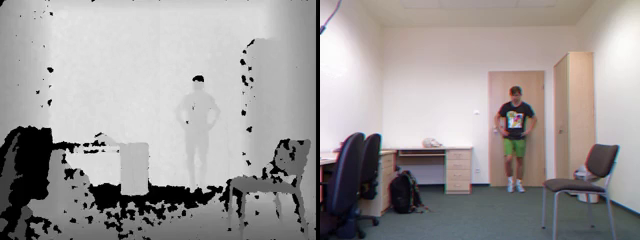

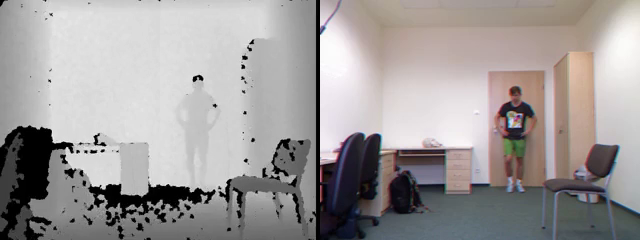

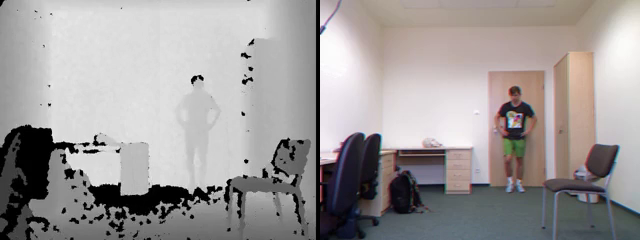

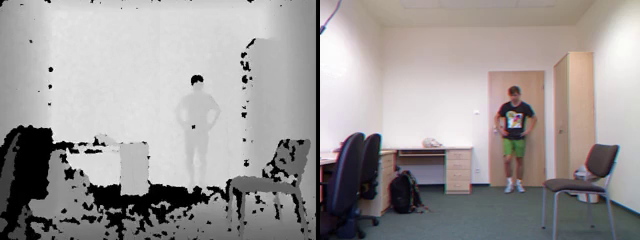

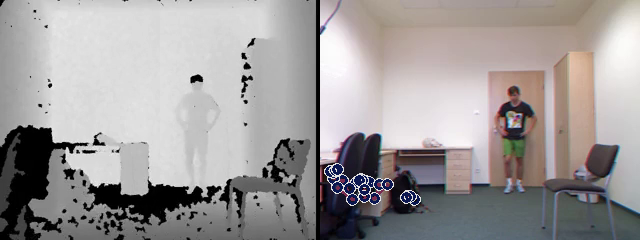

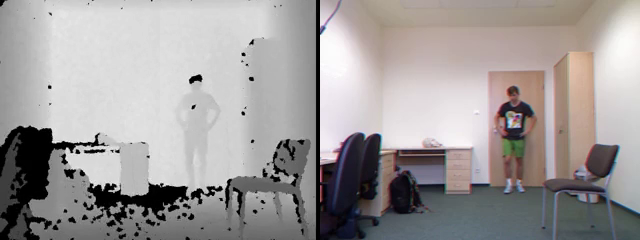

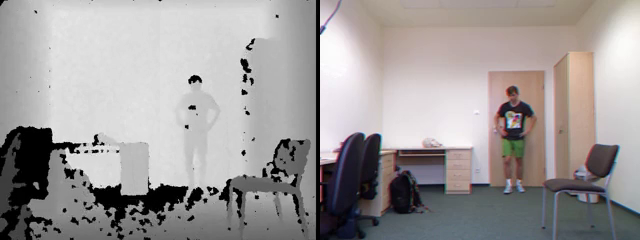

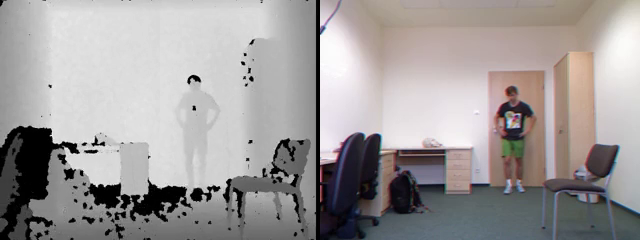

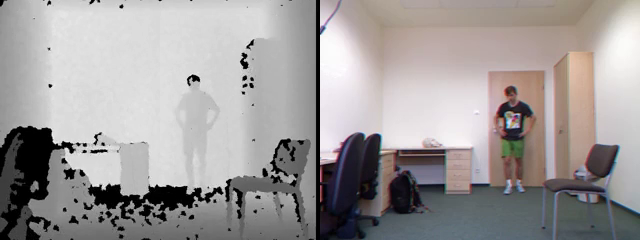

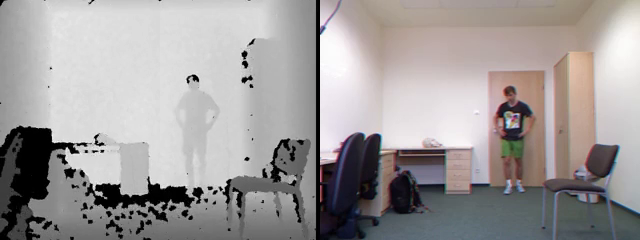

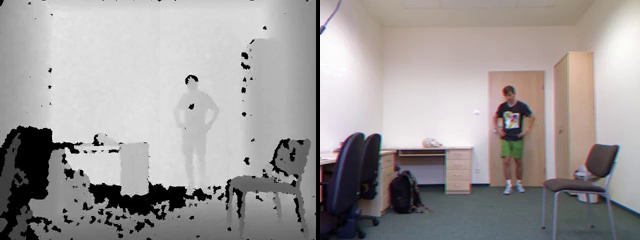

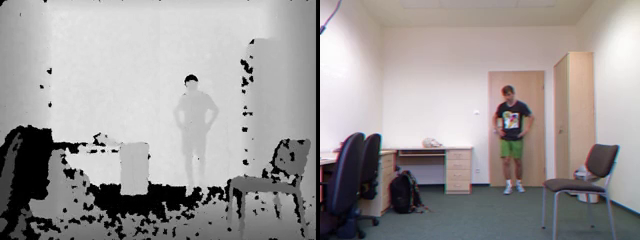

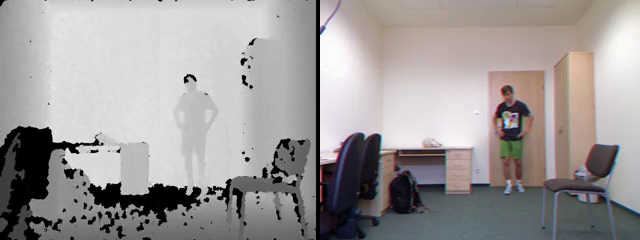

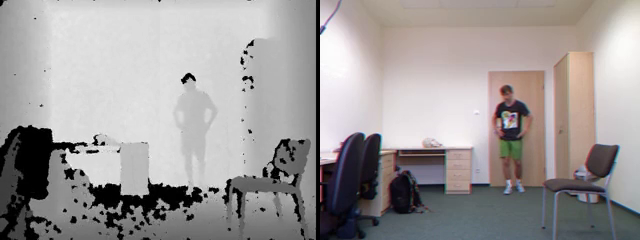

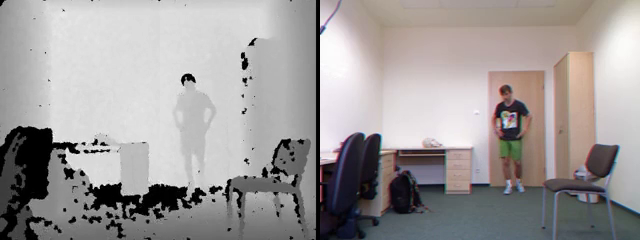

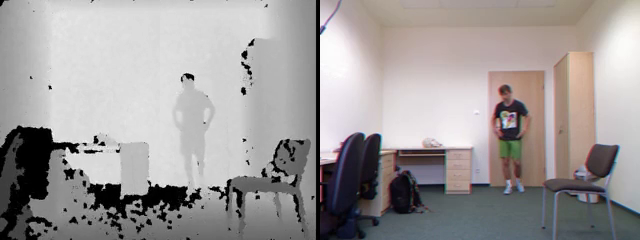

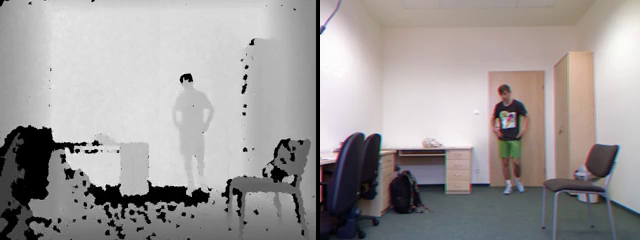

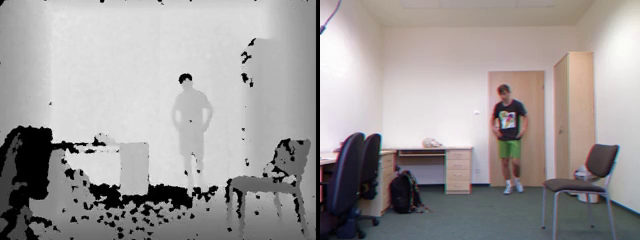

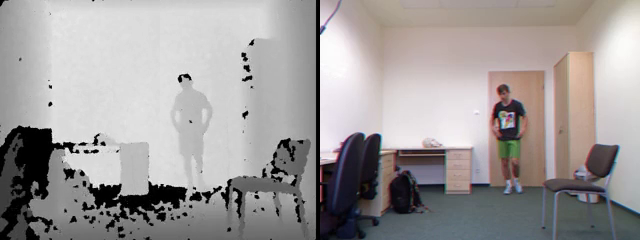

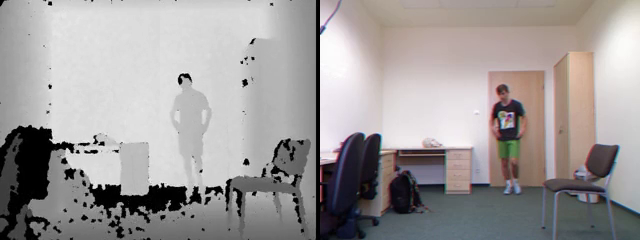

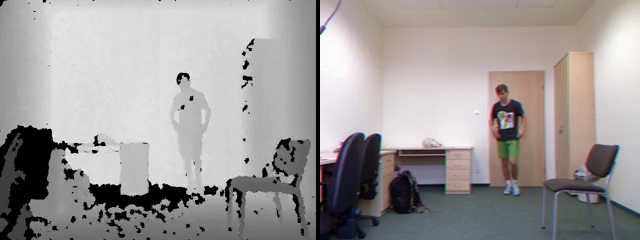

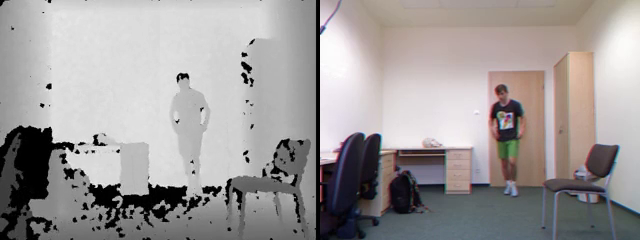

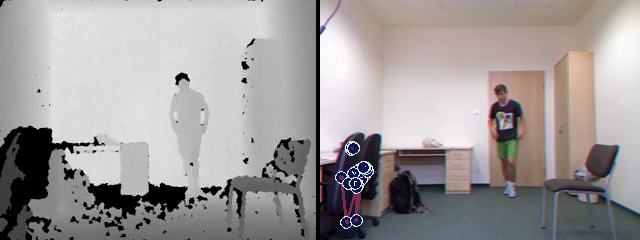

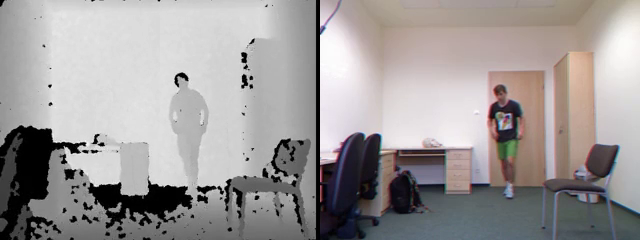

In [ ]:
from google.colab.patches import cv2_imshow  # import as substitution for cv2.imshow, for use in google colab

# CHOOSE THE RIGHT PATHS FOR EACH TYPE OF ACTION, AND THEN RUN THE CELL: 

# define the folder path of each action category 
action_path ='/content/MP_Data/fall/'
#action_path ='/content/MP_Data/no fall/'

# define the folder path of the videos for each action category (to read the videos from)
video_path ='/content/MP_Data/fall/video/'
#video_path ='/content/MP_Data/no fall/video/'

# for every video in the video path
for i in range(1,no_videos+1):

    frame_counter = 1

    cap = cv2.VideoCapture(video_path+str(i)+".mp4")

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        while cap.isOpened():                            

            ret, frame = cap.read()                      

            if ret==True:

                image, results = mediapipe_detection(frame, holistic)
                
                draw_styled_landmarks(image, results)

                keypoints = extract_keypoints(results)
                
                npy_path = os.path.join(action_path, str(i), str(frame_counter))
                np.save(npy_path, keypoints)
                frame_counter+=1

                # Show to screen (optional)
                #cv2.imshow('OpenCV Feed', image)           # in jupyter
                cv2_imshow(image)                           # in colab

                if cv2.waitKey(10) & 0xFF == ord('q'):      
                   break                                   
            
            else:
                break
        
        cap.release()                                   
        cv2.destroyAllWindows()                         


# 6. Preprocess Data and Create Labels and Features

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

{'fall': 0, 'no fall': 1}

In [ ]:
# COMBINE INTO ONE BIG ARRAY

sequences, labels = [], []
for action in actions:

    for sequence in range(1,no_videos+1):
        
        window = []       
        
        folder_path = os.path.join(DATA_PATH,action,str(sequence),"")   # adding "" will add a "/" to the folder_path at the end
        no_npy_files = len(os.listdir(folder_path))
        sequence_length = no_npy_files

        for frame_num in range(1,sequence_length+1): 
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        
        sequences.append(window)

        labels.append(label_map[action])


In [ ]:

# to identify the max_frames amongst all the videos:
max_frames = 0
for action in actions:
  for sequence in range(1,no_videos+1):
    folder_path = os.path.join(DATA_PATH,action,str(sequence),"")   # adding "" will add a "/" to the folder_path at the end
    no_npy_files = len(os.listdir(folder_path))
    if no_npy_files > max_frames:
      max_frames = no_npy_files

print(max_frames)

# To pad the remaining columns with zeros for the shorter videos 
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences, dtype='float32', padding='post') 

400


In [ ]:
# the following should give array of: 
# (no of videos X no of actions)rows * (no of frames)columns * (no of keypoints per frame)
np.array(sequences).shape

(60, 400, 132)

In [ ]:
# the following should give array of: 
# (no of videos X no of actions)rows * 1 column (single number representation)
np.array(labels).shape

(60,)

In [ ]:
# Assign X as the array of sequences
X = np.array(sequences)

In [ ]:
X.shape

(60, 400, 132)

In [ ]:
# convert labels via one hot encoding matrix for target y-matrix
y = to_categorical(labels).astype(int)

In [ ]:
# (no of videos) rows-BY-(no. of actions) columns, after onehotencoding
y.shape

(60, 2)

In [ ]:
# split the X and the corresponding y for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
# no. of split out rows-BY-(no. of actions) columns
y_test.shape

(6, 2)

In [ ]:
# Check if there is any Nan values:

np.isnan(X_train).any()

np.isnan(y_train).any()

np.isnan(X_test).any()

np.isnan(y_test).any()

False

# 7. Build and Train LSTM Neural Network

In [ ]:
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Masking
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
# can view the training performance via Tensorboard

In [ ]:
# Define the neural network model (no of layers, type and other parameters)
# Using Keras

model = Sequential()
#keras.layers.normalization.BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None)
model.add(Masking(mask_value=0., input_shape=(400,132)))
#model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(400,132)))
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(400,132)))  
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))    

In [ ]:
optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)     

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])    

In [ ]:
model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])    

Epoch 1/500
2/2 [==============================] - 8s 2s/step - loss: 0.6895 - categorical_accuracy: 0.5228
Epoch 2/500
2/2 [==============================] - 2s 943ms/step - loss: 0.6553 - categorical_accuracy: 0.5000
Epoch 3/500
2/2 [==============================] - 2s 998ms/step - loss: 0.6032 - categorical_accuracy: 0.6898
Epoch 4/500
2/2 [==============================] - 2s 969ms/step - loss: 0.5448 - categorical_accuracy: 0.8121
Epoch 5/500
2/2 [==============================] - 2s 970ms/step - loss: 0.5898 - categorical_accuracy: 0.6586
Epoch 6/500
2/2 [==============================] - 2s 1s/step - loss: 0.5464 - categorical_accuracy: 0.9402
Epoch 7/500
2/2 [==============================] - 2s 1000ms/step - loss: 0.4868 - categorical_accuracy: 0.8596
Epoch 8/500


KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 400, 132)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 400, 64)           50432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 128)          98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6

# 8. Make Predictions

In [ ]:
res = model.predict(X_test)

In [ ]:
# prediction, for res[i]
actions[np.argmax(res[0])]

'fall'

In [ ]:
# to check against corresponding the actual action, if prediction is right for res[i]
actions[np.argmax(y_test[0])]

'fall'

# 9. Save Weights

In [ ]:
model.save('action.h5')

In [ ]:
del model

In [ ]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 1],
        [0, 3]],

       [[3, 0],
        [1, 2]]])

In [ ]:
accuracy_score(ytrue, yhat)

0.8333333333333334

# 11. Test in Real Time

In [ ]:
from scipy import stats

In [ ]:
# define dynamic probability bars of detections for showing on-screen

# 2 different colors arrays created, one for each action
colors = [(245,117,16), (117,245,16)]

# define visualization probability and define indication of the respective probability bars for the different actions
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):  
        
        # create the dynamic rectangles to indicate the prob of each action shown on screen
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)  

        # create the texts (for the actions)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))      

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 400, 132)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 400, 64)           50432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 128)          98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6

In [ ]:
# if using local video for video action detection/prediction, run this cell

from google.colab.patches import cv2_imshow  # import as substitution for cv2.imshow, for use in google colab

# New detection variables
sequence = []     
sentence = []     
predictions = []  
threshold = 0.3

max_frames = 40

# modify following based on filepath of video
cap = cv2.VideoCapture('/content/MP_Data/how elderly falls.mp4')

# Convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec, fps and create VideoWriter object. The output is stored in 'output.avi' file.
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 15, (frame_width,frame_height))     

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():

        ret, frame = cap.read()         

        if ret==True:
        
            image, results = mediapipe_detection(frame, holistic)   
            print(results)

            draw_styled_landmarks(image, results)
            
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)           
            sequence = sequence[-max_frames:]   

            # if (max_frames) no. of frames are collected, then can generate predictions
            if len(sequence) == max_frames:              
                res = model.predict(np.expand_dims(sequence, axis=0))[0]      
                print(actions[np.argmax(res)])  
                predictions.append(np.argmax(res))    # append the index of the most confident action 
           
                #3. Visualisation logic
                if np.unique(predictions[-10:])[0]==np.argmax(res):     # to make sure the last ten frames have the same prediction, 
                                                                        # before confirming the predicted action 
                    if res[np.argmax(res)] > threshold:     
                        # only append the current action if the current predicted action is different from previous predicted action
                        if len(sentence) > 0:               
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                        
                if len(sentence) > 5: 
                    sentence = sentence[-5:]

                # To show the Visualisation probabilities / dynamic probability bars of detections in the real-time test video
                # This is optional, to hash following line if not needed.
                image = prob_viz(res, actions, image, colors)

            # For rectangle bar and actions located at the top of the screen  
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)      
            cv2.putText(image, ' '.join(sentence), (3,30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                
            out.write(image)
            
            # Show to screen (optional)
            #cv2.imshow('OpenCV Feed', image)           # in jupyter
            cv2_imshow(image)                           # in colab

            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        else:
            break


    cap.release()           
    
    out.release()           
    
    cv2.destroyAllWindows()